In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates

import random
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam
#from tensorboardX import SummaryWriter
import gymnasium as gym

from mplfinance.original_flavor import candlestick_ohlc

import random

## Utility

In [46]:
class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, render_range):
        self.volume = deque(maxlen=render_range)
        self.net_worth = deque(maxlen=render_range)
        self.render_data = deque(maxlen=render_range)
        self.render_range = render_range

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

    # Render the environment to the screen
    def render(self, date, open, high, low, close, volume, net_worth, trades):
        # append volume and net_worth to deque list
        self.volume.append(volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        date = mpl_dates.date2num([pd.to_datetime(date)])[0]
        self.render_data.append([date, open, high, low, close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='red', colordown='blue', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        date_render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(date_render_range, self.volume, 0)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(date_render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['Date'])])[0]
            if trade_date in date_render_range:
                if trade['Type'] == 'buy':
                    high_low = trade['Low']-10
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['High']+10
                    self.ax1.scatter(trade_date, high_low, c='blue', label='blue', s = 120, edgecolors='none', marker="v")

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.yaxis.set_label_position('right')
        self.ax3.set_ylabel('Balance') # 여기 수정

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        plt.show(block=False)
        # Necessary to view frames before they are unrendered
        plt.pause(0.001)

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.Transition = namedtuple('Transition',
                                ('state', 'action', 'next_state', 'reward'))

    def push(self, *args):
        """Save a transition"""
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


## Model

In [47]:

class Actor(nn.Module):
    def __init__(self, state_size):
        super(Actor, self).__init__()
        self.n_actions = 1
        self.state_size = state_size

        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(500, 256)
        self.layer2 = nn.Linear(256, 64)
        self.layer3 = nn.Linear(64, self.n_actions) # continuos action space니까 1이 되어야 하지 않을까? # 
        # action size: 여기서는 비트코인 한 종류만 다루고 있으므로 마지막을 1로 처리
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))

        return torch.tanh(x) # tanh 함수는 결과값을 -1에서 1 사이로 가두어 준다. 그러므로 continuous action space에 알맞다.

class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.n_actions = 1
        # Layer 1
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(500, 256)
        self.batch_norm_1 = nn.BatchNorm1d(256)

        # Layer 2
        # In the second layer the actions will be inserted also 
        self.layer2 = nn.Linear(256 + self.n_actions, 64)
        self.batch_norm_2 = nn.BatchNorm1d(64)

        # Output layer (single value)
        self.layer3 = nn.Linear(64, 1)


    def forward(self, inputs, action):

        # Layer 1
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)

        # Layer 2
        x = torch.cat((x, action), 1)  # Insert the actions
        x = self.layer2(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)

        return self.layer3(x) # Value라서 x 대신 V라고도 부른다.

In [48]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

## Environment

In [49]:
class TradingEnv:
    # A custom Bitcoin trading environment
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, render_range = 100):
        # Define action space and state size and other custom parameters
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.render_range = render_range # render range in visualization

        self.BATCH_SIZE = 500
        self.GAMMA = 0.99
        self.EPS_START = 0.9
        self.EPS_END = 0.05
        self.EPS_DECAY = 1000
        self.TAU = 0.005
        self.LR = 1e-4

        #self.OU = OU_noise(1)

    
        self.memory = ReplayMemory(1000)

        # Action space from -1 to 1. -1
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,)) 

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        # State size contains Market+Orders history for the last lookback_window_size steps
        self.state_size = (self.lookback_window_size, 10)

        self.Actor = Actor(self.state_size).to(device)
        self.Critic = Critic(self.state_size).to(device)

        self.optimizer = optim.Adam(self.Actor.parameters(), lr=self.LR)

    # Create tensorboard writer
#    def create_writer(self):
#        self.replay_count = 0
#        self.writer = SummaryWriter(comment="Crypto_trader")

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(render_range=self.render_range) # init visualization
        self.trades = deque(maxlen=self.render_range) # limited orders memory for visualization
        
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.crypto_held = 0
        self.crypto_sold = 0
        self.crypto_bought = 0
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
            self.market_history.append([self.df.loc[current_step, 'open'],
                                        self.df.loc[current_step, 'high'],
                                        self.df.loc[current_step, 'low'],
                                        self.df.loc[current_step, 'close'],
                                        self.df.loc[current_step, 'volume']
                                        ])

        state = np.concatenate((self.market_history, self.orders_history), axis=1)
        return state

    # Get the data points for the given current_step
    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'open'],
                                    self.df.loc[self.current_step, 'high'],
                                    self.df.loc[self.current_step, 'low'],
                                    self.df.loc[self.current_step, 'close'],
                                    self.df.loc[self.current_step, 'volume']
                                    ])
        obs = np.concatenate((self.market_history, self.orders_history), axis=1)

        #obs = np.concatenate((np.array(self.market_history), np.array(self.orders_history.cpu())), axis=1)
        #obs =torch.cat([self.market_history, self.orders_history], dim=0)

        return obs

    # Execute one time step within the environment
    def step(self, action):
        #action = action.cpu() # 새로 추가한 부분
        self.crypto_bought = 0
        self.crypto_sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        current_price = random.uniform(
            self.df.loc[self.current_step, 'open'],
            self.df.loc[self.current_step, 'close'])
        date = self.df.loc[self.current_step, 'date_open'] # for visualization
        high = self.df.loc[self.current_step, 'high'] # for visualization
        low = self.df.loc[self.current_step, 'low'] # for visualization
        
        if action == 0: # Hold
            pass
        
        elif action > 0 and self.balance > self.initial_balance/100: # 0이 아닌 이유: 가끔 오류가 날 때 있음
            self.crypto_bought = self.balance * action / current_price # 현금 * action으로 정해진 비율만큼 이용해서 구매
            self.balance -= self.crypto_bought * current_price
            self.crypto_held += self.crypto_bought
            self.trades.append({'Date' : date, 'High' : high, 'Low' : low, 'Total': self.crypto_bought, 'Type': "buy"})
        
        elif action < 0 and self.crypto_held * abs(action) > 0: 
            self.crypto_sold = self.crypto_held * abs(action) 
            self.balance += self.crypto_sold * abs(action) * current_price
            self.crypto_held -= self.crypto_sold
            self.trades.append({'Date' : date, 'High' : high, 'Low' : low, 'Total': self.crypto_sold, 'Type': "sell"})

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.crypto_held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
        #Write_to_file(Date, self.orders_history[-1])

        # Calculate reward
        reward = (self.net_worth - self.prev_net_worth)

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation()
        #obs = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        return obs, reward, done

    # render environment
    def render(self, visualize=False):
        #print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')
        if visualize:
            date = self.df.loc[self.current_step, 'date_open']
            open = self.df.loc[self.current_step, 'open']
            close = self.df.loc[self.current_step, 'close']
            high = self.df.loc[self.current_step, 'high']
            low = self.df.loc[self.current_step, 'low']
            volume = self.df.loc[self.current_step, 'volume']

            # Render the environment to the screen
            self.visualization.render(date, open, high, low, close, volume, self.net_worth, self.trades)
    
    def act(self, state, testmode): # select_action에 대응
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            action = self.Actor(state) 
        #sample = random.random()
        #eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * np.exp(-1 * self.current_step / self.EPS_DECAY)

        #state_with_noise = torch.tensor(state_with_noise, dtype=torch.float32, device=device).unsqueeze(0)
        #action_with_noise = action + torch.rand(1, device=device) * 0.1
        action = action.cpu()
        action_with_noise = action + np.random.rand(1) * 0.1    
        if action_with_noise > 1:
            action_with_noise = 1
        elif action_with_noise < -1:
            action_with_noise = -1
        
        if testmode == False:
            #return torch.tensor([[action_with_noise]], device=device, dtype=torch.long)
            return action_with_noise
        else:
            #return torch.tensor([[action]], device=device, dtype=torch.long)
            return action


        #if sample > eps_threshold:
        #    with torch.no_grad():
        #        return self.Actor(state).max(1).indices.view(1,1)
        #else:
        #    return torch.tensor([[np.random.choice(self.action_space)]], device=device, dtype=torch.long)
    

    def save(self, name="ddpg"):
        torch.save(self.Critic.state_dict(), f'./ddpg/{name}_Actor.h5')
        torch.save(self.Actor.state_dict(), f'./ddpg/{name}_Critic.h5')

    def load(self, name="dqn"):
        self.Actor.load_state_dict(torch.load(f'./ddpg/{name}_Actor.h5', weights_only=True))
        self.Critic.load_state_dict(torch.load(f'./ddpg/{name}_Critic.h5', weights_only=True))
        
    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.Actor(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.Critic(non_final_next_states).max(1).values
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.Actor.parameters(), 100)
        self.optimizer.step()
        

def train_agent(env, visualize=False, testmode=False, train_episodes=1, training_batch_size=500):
    #env.create_writer() # create TensorBoard writer
    #total_average = deque(maxlen=100) # save recent 100 episodes net worth
    #best_average = 0 # used to track best average net worth
    memory = ReplayMemory(1000)
    
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        for t in range(training_batch_size):
            env.render(visualize)
            action = env.act(state, testmode=testmode)
            next_state, reward, done = env.step(action)
            #action_onehot = np.zeros(3)
            #action_onehot[action] = 1
            memory.push(state, action, next_state, reward) # Store the transition in memory
            #next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            state = next_state
            env.optimize_model() # perform one step of the optimization on the policy network

            print(f"net_worth: {env.net_worth}, step: {env.current_step}")
            if episode == train_episodes - 1:
                env.save()

            if done:
                break
    
def test_agent(env, visualize=True, test_episodes=1):
    env.load() # load the model
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action = env.act(state, mode='test')
            state, reward, done = env.step(action)
            print(f"Episode {episode} net_worth:, {env.net_worth}")
            if env.current_step == env.end_step:
                break



In [50]:
import pandas as pd

lookback_window_size = 50
data_path = "./data/binance-BTCUSDT-1h.pkl"
df = pd.read_pickle(data_path)
train_size = int(len(df) * 0.7)
train_df = df[:train_size]
test_df = df[train_size:]

In [51]:
train_df

,open,high,low,close,volume,date_close
date_open,,,,,,
2020-03-31 00:00:00,6394.45,6469.28,6380.00,6439.55,3456.744826,2020-03-31 01:00:00
2020-03-31 01:00:00,6439.55,6515.00,6439.55,6514.07,2564.814102,2020-03-31 02:00:00
2020-03-31 02:00:00,6514.78,6523.23,6445.00,6449.66,2638.245186,2020-03-31 03:00:00
2020-03-31 03:00:00,6449.62,6480.00,6408.00,6439.47,3522.060908,2020-03-31 04:00:00
2020-03-31 04:00:00,6439.47,6465.00,6378.00,6398.93,3855.135175,2020-03-31 05:00:00
...,...,...,...,...,...,...
2023-03-20 19:00:00,27980.02,28013.00,27633.17,27785.10,16860.839580,2023-03-20 20:00:00
2023-03-20 20:00:00,27784.57,28034.19,27752.94,28001.00,12624.378950,2023-03-20 21:00:00
2023-03-20 21:00:00,28002.37,28186.71,27921.68,27996.09,11012.975200,2023-03-20 22:00:00


In [52]:
test_df

,open,high,low,close,volume,date_close
date_open,,,,,,
2023-03-21 00:00:00,27717.01,27953.33,27664.51,27850.21,15105.73382,2023-03-21 01:00:00
2023-03-21 01:00:00,27850.21,27934.63,27711.00,27875.65,13164.86421,2023-03-21 02:00:00
2023-03-21 02:00:00,27874.60,27907.80,27773.29,27779.74,11442.54447,2023-03-21 03:00:00
2023-03-21 03:00:00,27779.74,27838.00,27726.13,27787.29,11236.18652,2023-03-21 04:00:00
2023-03-21 04:00:00,27787.29,27968.00,27780.05,27906.81,12637.07836,2023-03-21 05:00:00
...,...,...,...,...,...,...
2024-06-27 11:00:00,61110.01,61314.20,61096.00,61196.02,580.05999,2024-06-27 12:00:00
2024-06-27 12:00:00,61196.01,61660.00,61154.60,61341.88,1198.51794,2024-06-27 13:00:00
2024-06-27 13:00:00,61341.87,61994.00,61314.00,61990.00,1761.82668,2024-06-27 14:00:00


In [63]:
test_df = df[train_size:]

In [64]:
len(train_df)

26016

In [65]:
len(test_df)

11151

In [53]:
actor = Actor(500).to(device)

In [54]:
state = np.random.rand(50,10)

In [56]:
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

In [57]:
output = actor(state)

In [58]:
output

tensor([[0.]], device='mps:0', grad_fn=<TanhBackward0>)

In [59]:
b = output.item()

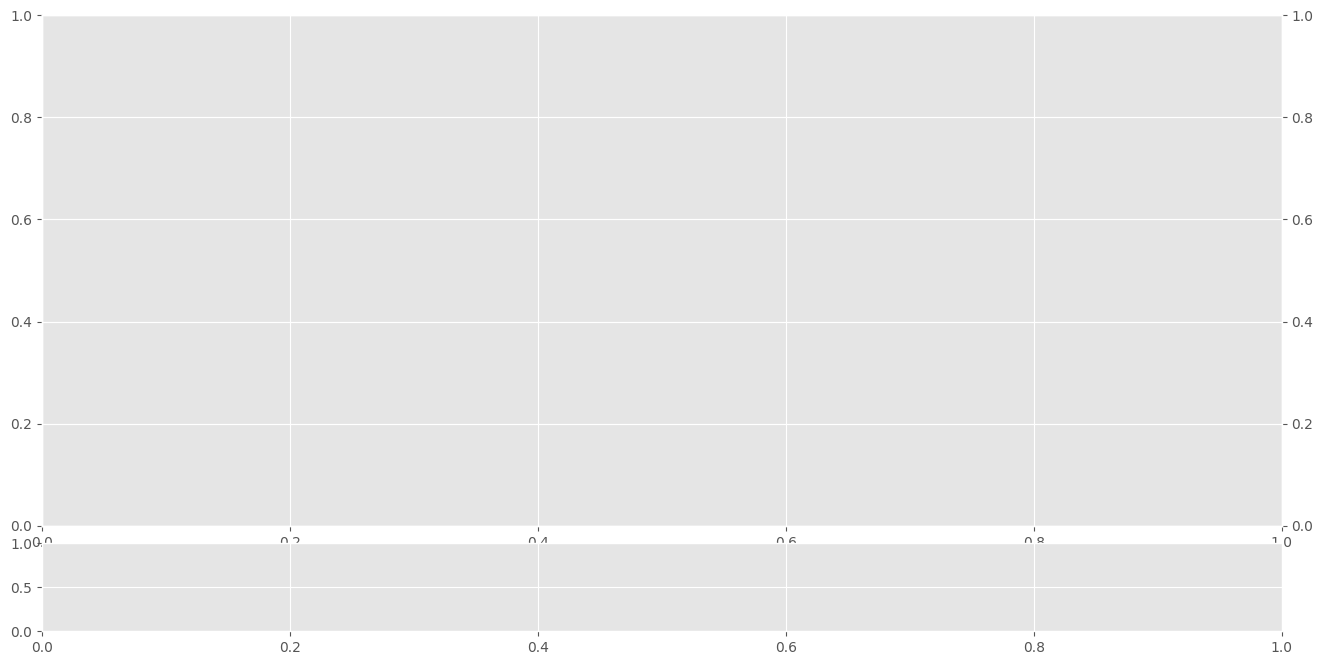

In [50]:
obs = train_env.reset()

In [51]:
obs

array([[ 6439.55    ,  6515.      ,  6439.55    ,  6514.07    ,
         2564.814102,  1000.      ,  1000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6514.78    ,  6523.23    ,  6445.      ,  6449.66    ,
         2638.245186,  1000.      ,  1000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6449.62    ,  6480.      ,  6408.      ,  6439.47    ,
         3522.060908,  1000.      ,  1000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6439.47    ,  6465.      ,  6378.      ,  6398.93    ,
         3855.135175,  1000.      ,  1000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6398.09    ,  6453.      ,  6380.96    ,  6415.6     ,
         2207.248162,  1000.      ,  1000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6415.6     ,  6471.56    ,  6390.      ,  6471.56    ,
         3093.525912,  1000.      ,  1000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6

In [52]:
train_env.market_history

deque([[6439.55, 6515.0, 6439.55, 6514.07, 2564.814102],
       [6514.78, 6523.23, 6445.0, 6449.66, 2638.245186],
       [6449.62, 6480.0, 6408.0, 6439.47, 3522.060908],
       [6439.47, 6465.0, 6378.0, 6398.93, 3855.135175],
       [6398.09, 6453.0, 6380.96, 6415.6, 2207.248162],
       [6415.6, 6471.56, 6390.0, 6471.56, 3093.525912],
       [6471.56, 6473.68, 6425.48, 6445.09, 2008.266984],
       [6445.11, 6505.5, 6441.71, 6493.93, 3412.169747],
       [6492.98, 6499.0, 6425.0, 6440.04, 3365.663583],
       [6440.04, 6441.3, 6404.0, 6431.32, 2779.521484],
       [6431.48, 6432.29, 6330.01, 6387.19, 5307.474472],
       [6387.73, 6461.95, 6321.4, 6447.37, 4797.736674],
       [6447.23, 6481.28, 6400.07, 6418.0, 4091.874182],
       [6418.0, 6484.95, 6415.15, 6452.04, 3234.975701],
       [6452.04, 6500.0, 6424.0, 6454.12, 3921.332904],
       [6454.12, 6469.94, 6414.05, 6427.59, 2812.788888],
       [6427.48, 6459.0, 6401.0, 6452.79, 2362.325763],
       [6452.79, 6486.6, 6444.82, 64

In [53]:
train_env.orders_history

deque([[1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [10

In [54]:
action = train_env.act(obs, testmode=False)

In [55]:
action

tensor([[0.0299]], dtype=torch.float64)

In [56]:
train_env.market_history

deque([[6439.55, 6515.0, 6439.55, 6514.07, 2564.814102],
       [6514.78, 6523.23, 6445.0, 6449.66, 2638.245186],
       [6449.62, 6480.0, 6408.0, 6439.47, 3522.060908],
       [6439.47, 6465.0, 6378.0, 6398.93, 3855.135175],
       [6398.09, 6453.0, 6380.96, 6415.6, 2207.248162],
       [6415.6, 6471.56, 6390.0, 6471.56, 3093.525912],
       [6471.56, 6473.68, 6425.48, 6445.09, 2008.266984],
       [6445.11, 6505.5, 6441.71, 6493.93, 3412.169747],
       [6492.98, 6499.0, 6425.0, 6440.04, 3365.663583],
       [6440.04, 6441.3, 6404.0, 6431.32, 2779.521484],
       [6431.48, 6432.29, 6330.01, 6387.19, 5307.474472],
       [6387.73, 6461.95, 6321.4, 6447.37, 4797.736674],
       [6447.23, 6481.28, 6400.07, 6418.0, 4091.874182],
       [6418.0, 6484.95, 6415.15, 6452.04, 3234.975701],
       [6452.04, 6500.0, 6424.0, 6454.12, 3921.332904],
       [6454.12, 6469.94, 6414.05, 6427.59, 2812.788888],
       [6427.48, 6459.0, 6401.0, 6452.79, 2362.325763],
       [6452.79, 6486.6, 6444.82, 64

In [59]:
train_env.orders_history

deque([[1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [1000, 1000, 0, 0, 0],
       [10

In [58]:
obs, reward, done = train_env.step(action)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (50, 5) + inhomogeneous part.

In [26]:
obs, reward, done = train_env.step(output)

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [7]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
plt.subplot(221)

# equivalent but more general
ax1 = plt.subplot(1, 3, 1)

# add a subplot with no frame
ax2 = plt.subplot(1,3,2)

ax3 = plt.subplot(1, 3, 3)

# add a polar subplot
plt.subplot(223, projection='polar')

# add a red subplot that shares the x-axis with ax1
plt.subplot(224, sharex=ax1, facecolor='red')

# delete ax2 from the figure
plt.delaxes(ax2)

# add ax2 to the figure again
plt.subplot(ax2)

# make the first Axes "current" again
plt.subplot(221)

In [3]:
import numpy as np

testarr = np.array([0])

In [4]:
testarr

array([0])

In [5]:
testarr[1] += 2

IndexError: index 1 is out of bounds for axis 0 with size 1

In [6]:
import torch

In [20]:
a = torch.tensor(-1.5)

In [21]:
a

tensor(-1.5000)

In [22]:
a = torch.clamp(a, -1.0, 1.0)

In [23]:
a

tensor(-1.)

In [34]:
from torch.distributions import Normal
a = torch.tensor(-1.5)
m = Normal(-1, 1.0)
#z = torch.atanh(torch.clamp(a, -1.0, 1.0))
log_prob_old = m.log_prob(a)

In [36]:
m

Normal(loc: -1.0, scale: 1.0)

In [38]:
action = torch.tensor(1)

In [43]:
action.item()

1

In [40]:
action.device

device(type='cpu')

In [ ]:


memory = deque([], maxlen=500)

In [63]:
c = [1, 2, 3, 4, 5]

In [64]:
c

[1, 2, 3, 4, 5]

In [65]:
torch.tensor(c)

tensor([1, 2, 3, 4, 5])

In [66]:
d = [[0, 1], [1, 2]]

In [67]:
torch.tensor(d)

tensor([[0, 1],
        [1, 2]])